# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [1]:
# Harry Potter -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip



!unzip -q data.zip

--2023-12-07 20:36:10--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2023-12-07 20:36:10--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip.3’

data.zip.3          100%[===================>]  36.61M  --.-KB/s    in 0.1s    

2023-12-07 20:36:10 (348 MB/s) - ‘data.zip.3’ saved [38392108/38392108]

replace data/class_dict? [y]es, [n]o, [A]ll

# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [2]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from torchvision import transforms
import cv2
from math import sqrt, log2
import numpy
from typing import List

In [3]:
!pip install pytorch-lightning -q
import pytorch_lightning as pl

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [4]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0] # Делим сначала по /, берем последний элемент XXXXXX.jpg, делим по ".", берем нулевой элемент XXXXXX
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml") # Получаем ./data/xmlsx/XXXXXX.xml
    treeroot = tree.getroot() # Получаем корень файла
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        xmin = int(member.find("bndbox").find("xmin").text)
        ymin = int(member.find("bndbox").find("ymin").text)
        xmax = int(member.find("bndbox").find("xmax").text)
        ymax = int(member.find("bndbox").find("ymax").text)
        class_in_dict = class_dict[member.find("name").text]
        res = (xmin, ymin, xmax, ymax, class_in_dict)

        bboxes.append(res)

    return bboxes # Возвращаем список с координатами нужных прямоугольников и правильными классами объектов в этих прямоугольниках

ОБРАТИМ ВНИМАНИЕ, ЧТО ОСЬ OY В КОМПЬЮТЕРНОМ ЗРЕНИИ НАЧИНАЕТСЯ СВЕРХУ, А ОСЬ ОХ, КАК МЫ ПРИВЫКЛИ, СЛЕВА.

In [5]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"  # Проверяем, что такая директория вообще существует

        self.filenames = np.array(glob.glob(root + "/images/*"))  # Имена всех файлов из корневой директории сохраняются в массив
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())  # Создание словаря "имя класса - число"

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}  # Обратный словарь число-имя класса (inversed)

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))  # Перемешиваем индексы картинок из filenames

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]  # Берем 90% выборки для трэйна
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]  # Берем 10% выборки для теста
            ].tolist()

    def __getitem__(self, idx):
        ### YOUR CODE HERE ###

        fname = self.filenames[idx]
        image = np.array(Image.open(fname).convert("RGB"))
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        ### YOUR CODE HERE ###
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [6]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [7]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [8]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)): # returns tuples like (0,axes0), (1,axes1), (2,axes2)...
        # Надо в каждой строке нарисовать рисунок + прямоугольники
        ax.axis(False)

        if i >= len(images):
            break

        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv

        # Сначала возращаем к исходному виду, а потом пермютим
        invTrans = transforms.Compose([transforms.Normalize(mean = (0., 0., 0.),
                                                     std = (1/0.229, 1/0.224, 1/0.225)),
                                       transforms.Normalize(mean = (-0.485, -0.456, -0.406),
                                                     std = (1., 1., 1.))]
                                      )
        image = invTrans(images[i])

        to_PIL = transforms.ToPILImage()
        image=np.array(to_PIL(image))

        for bbox in bboxes[i]: # bbox -> (xmin, ymin, xmax, ymax, class_in_dict) таких прямоугольников для каждой картинки n штук, поэтому для i-ой картинки нам надо нарисовать все прямоугольники
        ### YOUR CODE HERE ###
          x1 = int(bbox[0])
          y1 = int(bbox[1])
          x2 = int(bbox[2])
          y2 = int(bbox[3])
          start_point = (x1, y1)
          end_point = (x2, y2)
          object_class = train_ds.class_dict_inv[bbox[4]]
          cv2.rectangle(image, start_point, end_point, color=(0,255,0), thickness=2)
          cv2.putText(image, object_class, (x1, y1-10), cv2.FONT_HERSHEY_TRIPLEX, 0.9, color=(0,255,0), thickness=1)

        ax.imshow(image)
    fig.tight_layout()
    plt.show()

https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

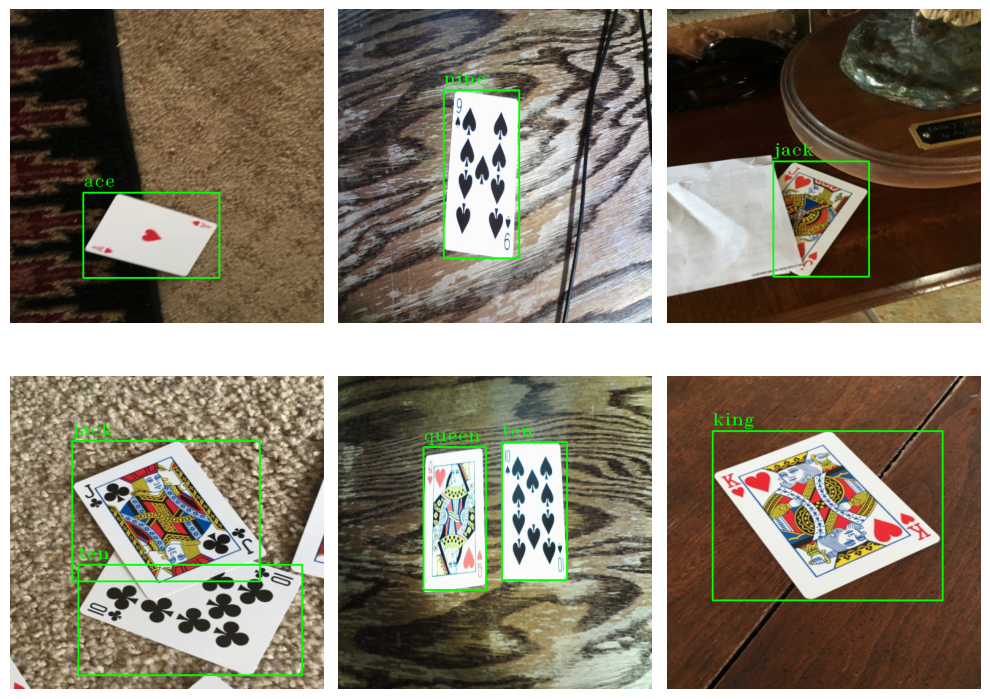

In [9]:
out = [train_ds[i] for i in range(6)] # берем 6 картинок
visualize([o["image"] for o in out], [o["bboxes"] for o in out]) # для каждой картнки рисуем ее и ее прямоугольники

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16.

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [10]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch]))) # для всех наборов (image, bboxes) из батча мы делаем два списка: imgs, содержащий все картинки батча, и bboxes, содержащий все прямоугольники для каждой картинки батча

    imgs = torch.stack(imgs) # соединяем по нулевой размерности: по числу картинок в батче - размерности батча
    b, _, h, w = imgs.shape # извлекаем размер батча, ширину и высоту картинки, _ - это число каналов, которое по дефолту 3

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample) # Создаем тензор из нулей для таргета размерности (b, 6, 16, 16)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes): # Возвращает (0, bboxes для 1 картинки), (1, bboxes для 2 картинки), (2, bboxes для 3 картинки)...
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        ) # torch.split поделит тензор, вернет пять тензоров, каждый с четырьмя размерностями, потом мы удалим ненужные размерности

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell =  downsample # TODO размер клетки по X в пикс
        y_cell =  downsample # TODO размер клетки по Y в пикс
        w_box =  (xmax - xmin) / w # TODO ширина бокса отнормированная в пикселях НАДО НОРМИРОВАТЬ НА 512 ИЛИ НА ДАУНСЭМПЛ???
        h_box =  (ymax - ymin) / h # TODO высота бокса отнормированная

        # Посчитайте координаты центра и сдвиги
        cx =  (xmax + xmin) / 2 # TODO (координаты центра в исходных координатах)
        cy =  (ymax + ymin) / 2 # TODO
        cx_idx =  cx // downsample # TODO (посчитайте индекс центра на карте признаков размера 16x16. Это будут как раз координаты пикселя, куда мы запишем параметры коробки)
        cy_idx = cy // downsample # TODO

        cx_box = (cx - cx_idx * downsample) / downsample # TODO (посчитайте сдивиги относительно cx_idx)
        cy_box = (cy - cy_idx * downsample) / downsample # TODO

        target[i, :, cy_idx.long(), cx_idx.long()] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )  # В таргете сохраняем для каждого кубика координаты центра внутри кубика, нормированные от 0 до 1 размеры bbox, confidence, классы - тензор с числами

    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

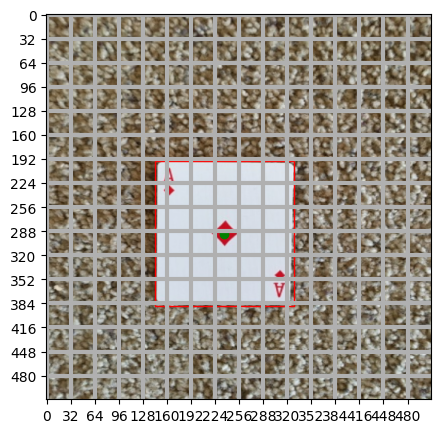

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1) # Возвращаем к исходному варианту картинку (ненормированная)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1] # object class
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2 # (x_min+x_max)/2 - так мы найдем координату х середины бокса
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2 # (y_min+y_max)/2 - так мы найдем координату у середины бокса

ax.scatter(cx, cy, color="green", marker="o") # Поставим точку в центре бокса

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx16x16x6. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [12]:
# Здесь нам надо написать функцию, которая по трешхолду будет возвращать для таргета bboxes, которые вообще есть, а для выхода сетки будет возвращать бибоксы, у которых вероятность трешхолда больше порога
def decode_prediction(pred, upsample=32, threshold=0.7): # Получаем на вход b*6*16*16 - cетку с кубиками
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample # Растягиваем картинку в полный рост
    ### YOUR CODE HERE ###
    # Сначала возьмем argmax, если это выход из нейронки - предсказанный наиболее вероятный класс
    if c == 6: # Если мы подали функции таргет, то в нем будет 6 каналов. target -> (b, 6, 16, 16)
      confidence = pred[:, 4, :, :] # (b, 16, 16)
      classes = pred[:, 5, :, :] # (b, 16, 16)
    else: # pred -> (x, y, w, h, obj_score, class_probabilities)
      confidence = pred[:, 4, :, :] # obj score на 5 ом месте - 4 по индексу
      classes = torch.argmax(pred[:, 5:, :, :], dim = 1) # берем максимум из всех классов и получаем один наиболее вероятный класс -> (b, 16, 16)
    mask = confidence > threshold # -> (b, 16, 16) Взяли маску, что конфидент больше трешхолда, то есть нашли квадраты, в которых с большой вероятностью лежат центры bbox
    # Проверим конфиденс, если он больше порога, то посчитаем все параметры бокса, взяв необходимые параметры из квадратика с 6 каналами
    decoder_bboxes = []
    for batch in range(b):
      for i in range(w):
        for j in range(h):
          if pred[batch, 4, j, i] > threshold: # Обратим внимание, что индекс по x идет 4 размерностью, а индекс по y идет 3 размерностью
            cx = (i + pred[batch, 0, j, i]) * upsample # (idx ячейки + нормированное расстояние от края квадратика до центра bbox) * upsample, чтобы перевести в пиксели
            cy = (j + pred[batch, 1, j, i]) * upsample
            # Посчитаем промежуточные матрицы. Я решил СЛАУ с помощью матриц
            mu = pred[batch, 2, j, i] * img_w # w_box * img_w
            sigma = pred[batch, 3, j, i] * img_h # h_box * h_img
            psi = cx * 2
            phi = cy * 2
            xmin = 0.5 * (psi - mu)
            ymin = 0.5 * (phi - sigma)
            xmax = 0.5 * (mu + psi)
            ymax = 0.5 * (phi + sigma)
            class_in_dict = pred[batch, 5, j, i]
            res = (float(xmin), float(ymin), float(xmax), float(ymax), int(class_in_dict))

            bboxes_for_image = []
            bboxes_for_image.append(res)
            decoder_bboxes.append(bboxes_for_image)
    return decoder_bboxes # bbox -> (xmin, ymin, xmax, ymax, class_in_dict)

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [14]:
# СТРАЙДА НЕТ ПО УСЛОВИЮ
C = 6  # Количество классов в вашем датасете, хоть руками посчитайте, хоть подтяните из словаря классов
class ConvBlock(pl.LightningModule):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)

class Detector(nn.Module):
    def __init__(self,
        in_channels: int = 3,
        out_channels: int = 1,
        features: List[int] = [11, 32, 128, 512, 2048],
        learning_rate: float = 1.5e-3,):
        super().__init__()
        self.model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.learning_rate = learning_rate
        self.up = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)  # Phase change
        self.sigma = nn.Sigmoid()
        for feature in reversed(features[1:]):
            self.up.append(
                ConvBlock(
                    in_channels=feature, out_channels=feature/2
                )  # x gets concat to 2xchannel
            )
        self.last_layer = nn.ConvBlock(in_channels = 32, out_channels = 11)

        self.classifier = nn.Sequential(self.up, self.last_layer, self.sigma)

        self.loss_fn = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.classifier, weight_decay=0.3
        )

    def forward(self, img):
        ### YOUR CODE HERE ###
        self.model.fc = nn.Identity() # Уберем полносвязный слой и будем иметь 2048 выходов из последнего Bottleneck
        # Будем последовательно уменьшать количество каналов 2048 -> 512 -> 128 -> 32 -> 5+C, для этого напишем блочный класс, обучать нам надо только то, что мы дописали, до этого момента все претрейнено
        for idx in range(0, len(self.up)): # Применим последовательно ConvBlock в сторону уменьшения числа каналов до 32
            x = self.up[idx](x)
        x = self.last_layer() # Применим последний слой, чтобы от 32 перейти к 11 каналам
        self.optimizer = torch.optim.Adam(self.classifier.parameters())
        return self.sigma(x)

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [17]:
def special_loss(pred, target, check=False, C=C):
    ### YOUR CODE HERE ###
    b, c, h, w = pred.shape
    mask = target[:, 4, :, :] > 0 # Для каждого батча для каждого кубика берем конфиденс и сравниваем с порогом -> (b, 16, 16), чтобы применить mask_select, нам нужна маска той же размерности, что и предикт
    # mask = mask.unsqueeze(1).expand_as(target)
    cx_boxes_select_t = torch.masked_select(target[:, 0, :, :], mask) # (b, 16, 16) Координаты cx_boxes для ячеек, в которых есть бибоксы
    cy_boxes_select_t = torch.masked_select(target[:, 1, :, :], mask) # (b, 16, 16)
    w_boxes_select_t = torch.masked_select(target[:, 2, :, :], mask) # (b, 16, 16)
    h_boxes_select_t = torch.masked_select(target[:, 3, :, :], mask) # (b, 16, 16)
    confidence_selected_t = torch.masked_select(target[:, 4, :, :], mask) # (b, 16, 16)
    classes_selected_t = torch.masked_select(target[:, 5, :, :], mask) # Получим конкретные классы для каждой ячейки, в которой есть bbox (b, 16, 16)
    cx_boxes_select_p = torch.masked_select(pred[:, 0, :, :], mask) # (b, 16, 16)
    cy_boxes_select_p = torch.masked_select(pred[:, 1, :, :], mask) # (b, 16, 16)
    w_boxes_select_p = torch.masked_select(pred[:, 2, :, :], mask) # (b, 16, 16)
    h_boxes_select_p = torch.masked_select(pred[:, 3, :, :], mask) # (b, 16, 16)
    confidence_selected_p = torch.masked_select(pred[:, 4, :, :], mask) # (b, 16, 16)
    classes_selected_p = torch.masked_select(pred[:, 5:, :, :], mask) # (b, 6, 16, 16)
    localization_loss = 1 / len(cx_boxes_select_p) * (((cx_boxes_select_p-cx_boxes_select_t) ** 2).sum() + ((cy_boxes_select_p-cy_boxes_select_t)**2).sum())
    box_loss = 1 / len(cx_boxes_select_p) * (sqrt(w_boxes_select_p) ** 2 + sqrt(w_boxes_select_t) ** 2).sum()
    classification_loss = 0
    confidence_loss_for_bboxes = 0
    bseloss = nn.BCELoss()
    confidence_loss = bseloss(pred, target)
    for batch in range(b):
      for i in range(w):
        for j in range(h):
          classification_loss += -log2(classes_selected_p[b, classes_selected_t[b, j, i], j, i]) # Заходим во вторую размерность и берем оттуда метку класса; после мы берем соответствующую этой метке класса вероятность из предикта, берем логарифм и добавляем в лосс
          confidence_loss_for_bboxes +=
    classification_loss = classification_loss / len(classes_selected_t)


    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss

    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

SyntaxError: ignored

In [ ]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=3) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS = 15 # Harry Potter 20, Cards 15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        ### YOUR CODE HERE ###



    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

Запустим обученный детектор на тестовых изображениях:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [ ]:
# Нужно сделать предсказание и переложить результат на cpu

### YOUR CODE HERE ###

In [ ]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1

### YOUR CODE HERE ###

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [15]:
!pip install ultralytics

## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [16]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [17]:
def annotation2txt(bboxes, w_im, h_im):
    ### YOUR CODE HERE ###
    yolo_annotations = [] # будем сюда добавлять аннотации, чтобы получить список аннотаций в виде строк

    for bbox in bboxes:
        x_min, y_min, x_max, y_max, class_id = bbox
        x_center = (x_min + x_max) / (2 * w_im) # Поделив на 2 найдем центр, потом нормируем на размер картинки
        y_center = (y_min + y_max) / (2 * h_im)
        width = (x_max - x_min) / w_im
        height = (y_max - y_min) / h_im

        yolo_annotation = f"{class_id} {x_center} {y_center} {width} {height}"
        yolo_annotations.append(yolo_annotation)

    return yolo_annotations

In [18]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )
    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [19]:
# Собираем YAML

nc = 6 # Укажите число классов. Хоть руками, хоть по-умному посчитайте (см. class_dict)
names = ['king', 'jack', 'ace', 'ten', 'nine', 'queen'] # Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [20]:
import ultralytics

### YOUR CODE HERE ###

# Загрузка модели
model = ultralytics.YOLO('yolov8n.yaml')  # предварительно обученная модель YOLOv8n

results = model.train(data='data.yaml', epochs=100)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

train: Scanning /content/train/labels... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<00:00, 2040.59it/s]

train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels... 37 images, 0 backgrounds, 0 corrupt: 100%|██████████| 37/37 [00:00<00:00, 816.67it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.68G      3.021      4.673      4.407         21        640: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]

                   all         37         68   0.000313     0.0732   0.000233   5.47e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.43G      2.951      4.348      4.097         18        640: 100%|██████████| 21/21 [00:07<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         37         68    0.00025     0.0524   0.000164   5.17e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.43G      2.886      3.943       3.84         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         37         68   0.000339     0.0499   0.000203   3.54e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.43G      2.849      3.675      3.601         27        640: 100%|██████████| 21/21 [00:07<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]


                   all         37         68   0.000262     0.0524   0.000187   3.62e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.43G      2.777      3.551      3.408         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         37         68      0.768     0.0434     0.0527     0.0211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.43G      2.725      3.427      3.258         17        640: 100%|██████████| 21/21 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


                   all         37         68      0.562     0.0896     0.0506     0.0225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.43G      2.631      3.192      3.115         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


                   all         37         68      0.131      0.187      0.119     0.0537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.43G      2.437      3.069      2.989         24        640: 100%|██████████| 21/21 [00:07<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         37         68      0.265      0.137      0.116     0.0689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.43G      2.256      2.885      2.873         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         37         68      0.469      0.219      0.246      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.43G       2.16      2.756      2.753         24        640: 100%|██████████| 21/21 [00:07<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


                   all         37         68      0.238       0.22      0.264      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.41G      2.003      2.638      2.631         20        640: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         37         68      0.198      0.404      0.293      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.43G      1.937      2.611      2.553         18        640: 100%|██████████| 21/21 [00:05<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


                   all         37         68      0.489      0.654      0.516       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.43G      1.809      2.482       2.37         22        640: 100%|██████████| 21/21 [00:06<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         37         68      0.292      0.762      0.455      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.46G      1.816      2.465      2.378         15        640: 100%|██████████| 21/21 [00:05<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


                   all         37         68      0.407      0.626       0.44      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.44G      1.685      2.359      2.268         23        640: 100%|██████████| 21/21 [00:07<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


                   all         37         68      0.395      0.594      0.456      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.44G       1.61      2.325      2.201         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]


                   all         37         68      0.392      0.566      0.507      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.43G      1.573      2.204      2.145         15        640: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         37         68      0.374      0.596      0.465      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.43G       1.47      2.161      2.046         21        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]


                   all         37         68      0.492      0.633      0.578      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.44G       1.42      2.137      1.992         15        640: 100%|██████████| 21/21 [00:07<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]


                   all         37         68      0.432      0.696       0.54      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.44G      1.333      2.024      1.909         17        640: 100%|██████████| 21/21 [00:05<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]


                   all         37         68      0.484      0.751      0.567      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.42G      1.346       2.03      1.936         22        640: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


                   all         37         68      0.448      0.673      0.482      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.44G      1.306      1.946      1.855         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

                   all         37         68       0.41      0.752      0.573      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.43G      1.308       1.92      1.836         29        640: 100%|██████████| 21/21 [00:07<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         37         68      0.416      0.711      0.502      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.44G      1.283      1.955      1.836         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         37         68      0.529      0.681      0.604      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.42G      1.234      1.865      1.786         23        640: 100%|██████████| 21/21 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         37         68      0.422      0.822      0.588      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.43G      1.196      1.782      1.756         22        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         37         68      0.508      0.715       0.57      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.43G        1.2      1.807      1.739         23        640: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


                   all         37         68      0.491      0.686       0.65      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.41G      1.182      1.767      1.713         19        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]

                   all         37         68       0.51      0.715      0.605      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.43G      1.174       1.75      1.698         14        640: 100%|██████████| 21/21 [00:06<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         37         68      0.523      0.868      0.694      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.43G      1.131      1.684      1.659         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         37         68      0.545      0.681      0.663      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.43G      1.086      1.662      1.623         26        640: 100%|██████████| 21/21 [00:06<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         37         68      0.459      0.847      0.635      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.43G      1.133      1.677      1.645         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         37         68      0.579      0.837      0.711       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.41G      1.084      1.615      1.606         28        640: 100%|██████████| 21/21 [00:06<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         37         68      0.542      0.733      0.708      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.43G      1.075       1.62      1.598         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         37         68      0.543      0.842      0.715        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.44G       1.04      1.573      1.554         21        640: 100%|██████████| 21/21 [00:06<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all         37         68      0.511       0.84      0.666      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.43G      1.049      1.566       1.55         20        640: 100%|██████████| 21/21 [00:06<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         37         68      0.492       0.85      0.702      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.41G      1.012      1.511      1.524         16        640: 100%|██████████| 21/21 [00:06<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         37         68      0.494      0.812      0.721      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.43G       1.01      1.498      1.506         15        640: 100%|██████████| 21/21 [00:06<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         37         68      0.563      0.845      0.738      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.43G     0.9815      1.504      1.494         33        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         37         68      0.656      0.754      0.747      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.43G     0.9879      1.492      1.497         39        640: 100%|██████████| 21/21 [00:06<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         37         68      0.849      0.699      0.814      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.42G     0.9561      1.456      1.477         22        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         37         68      0.627      0.839      0.771      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.43G      0.934      1.432      1.456         38        640: 100%|██████████| 21/21 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         37         68      0.592       0.81      0.729      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.43G     0.9427      1.426      1.473         16        640: 100%|██████████| 21/21 [00:05<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         37         68      0.642      0.782      0.743       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.43G      0.911      1.398      1.426         29        640: 100%|██████████| 21/21 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         37         68      0.526      0.816      0.775      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.42G     0.9117      1.382      1.442         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         37         68      0.614      0.827      0.731      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.43G     0.9086      1.395      1.439         27        640: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         37         68      0.693      0.853      0.797      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.43G     0.9284      1.378      1.436         23        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         37         68      0.641      0.923      0.807      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.43G     0.9096      1.341      1.416         34        640: 100%|██████████| 21/21 [00:07<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         37         68       0.57      0.814      0.774      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.41G      0.872       1.31      1.401         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]


                   all         37         68      0.689      0.854      0.832      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.43G     0.8938      1.304       1.42         21        640: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         37         68      0.604      0.739      0.784      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.43G     0.8971      1.311       1.42         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         37         68       0.65      0.879       0.86      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.43G     0.8922      1.255        1.4         26        640: 100%|██████████| 21/21 [00:07<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


                   all         37         68      0.838      0.692      0.837      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.43G     0.8703       1.31      1.381         15        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


                   all         37         68      0.576      0.855      0.806      0.694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.44G     0.8704      1.284      1.405         28        640: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


                   all         37         68      0.712      0.819       0.85      0.748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.43G     0.8286      1.222      1.362         22        640: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         37         68      0.645      0.729      0.754       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.43G      0.841      1.268      1.371         27        640: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         37         68      0.552      0.849      0.772      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.42G     0.8058      1.218      1.341         22        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         37         68       0.77      0.924      0.922      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.43G     0.8302      1.199      1.357         34        640: 100%|██████████| 21/21 [00:06<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]


                   all         37         68      0.588       0.94      0.798      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.43G     0.8431      1.222      1.354         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         37         68      0.541      0.883      0.759      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.41G     0.8067      1.181       1.32         17        640: 100%|██████████| 21/21 [00:06<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         37         68      0.697      0.943      0.844      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.41G     0.7955      1.172      1.334         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         37         68      0.822      0.769      0.893      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.44G      0.803      1.134      1.336         24        640: 100%|██████████| 21/21 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         37         68      0.819      0.787      0.887      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.43G     0.8094      1.195       1.35         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         37         68      0.715      0.874      0.884      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.43G     0.7902      1.132      1.313         18        640: 100%|██████████| 21/21 [00:06<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         37         68      0.739      0.745      0.827      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.43G     0.8171      1.175      1.345         20        640: 100%|██████████| 21/21 [00:06<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         37         68       0.87      0.819      0.912      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.43G     0.7802       1.11      1.302         38        640: 100%|██████████| 21/21 [00:06<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]


                   all         37         68      0.848      0.825      0.895      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.43G     0.8094      1.151      1.346         12        640: 100%|██████████| 21/21 [00:06<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         37         68      0.829      0.833      0.878      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.43G     0.7721      1.052      1.297         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         37         68      0.903      0.825      0.904      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.43G     0.7667      1.065      1.286         19        640: 100%|██████████| 21/21 [00:06<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         37         68      0.897      0.813      0.914      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.43G     0.7581      1.054      1.289         21        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


                   all         37         68      0.811      0.913      0.923       0.81

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.43G     0.7714      1.068      1.285         21        640: 100%|██████████| 21/21 [00:07<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         37         68      0.787       0.79      0.891      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.43G     0.7651      1.041      1.297         15        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         37         68      0.862      0.834       0.92      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.43G     0.7682      1.069      1.303         16        640: 100%|██████████| 21/21 [00:07<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         37         68      0.877      0.899      0.946      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.43G     0.7539      1.037      1.283         16        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


                   all         37         68      0.911      0.799       0.93       0.82

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.44G     0.7479      1.037      1.278         16        640: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]


                   all         37         68      0.889      0.925      0.968      0.845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.44G     0.7503      1.019      1.288         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

                   all         37         68      0.897      0.848      0.907      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.43G     0.7264      1.016      1.265         21        640: 100%|██████████| 21/21 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         37         68      0.868      0.872       0.92      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.43G     0.7314     0.9967      1.268         21        640: 100%|██████████| 21/21 [00:05<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

                   all         37         68      0.838      0.889      0.915      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.43G     0.7298      1.021      1.284         22        640: 100%|██████████| 21/21 [00:07<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         37         68      0.907       0.82      0.901      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.43G     0.7196      1.001      1.259         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         37         68      0.915      0.841       0.94      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.43G      0.719     0.9787      1.266         19        640: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         37         68      0.864      0.792      0.889      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.43G     0.7202     0.9794      1.258         19        640: 100%|██████████| 21/21 [00:05<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]


                   all         37         68      0.854      0.903      0.964      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.43G     0.7087     0.9796      1.242         16        640: 100%|██████████| 21/21 [00:07<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         37         68      0.891      0.864      0.945      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.43G     0.7163     0.9691      1.261         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         37         68      0.954      0.834      0.957      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.43G     0.7199     0.9789      1.264         28        640: 100%|██████████| 21/21 [00:06<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         37         68      0.854      0.884      0.944      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.43G     0.6832     0.9269      1.224         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         37         68      0.945      0.877      0.969      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.43G     0.6803      0.934      1.223         22        640: 100%|██████████| 21/21 [00:06<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         37         68      0.915      0.818      0.929      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.44G     0.6793     0.9296      1.217         13        640: 100%|██████████| 21/21 [00:06<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         37         68      0.936      0.847      0.961      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.43G     0.6796     0.9081      1.224         19        640: 100%|██████████| 21/21 [00:06<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         37         68      0.927       0.92      0.973      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.43G     0.7194     0.9481      1.267         28        640: 100%|██████████| 21/21 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         37         68      0.925      0.925      0.977      0.878


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.55G     0.5585     0.8078      1.098         15        640: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         37         68       0.93      0.865      0.939      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.41G     0.5382     0.8063        1.1         11        640: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         37         68      0.952      0.916      0.975      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.41G     0.5145      0.707      1.079         12        640: 100%|██████████| 21/21 [00:05<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]


                   all         37         68      0.943      0.833      0.942      0.852

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.41G     0.5175     0.7312      1.064         11        640: 100%|██████████| 21/21 [00:07<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         37         68      0.912      0.921       0.97      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.41G     0.4943      0.708      1.047         10        640: 100%|██████████| 21/21 [00:05<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

                   all         37         68      0.928      0.891      0.951      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.42G     0.4945     0.7234      1.067         14        640: 100%|██████████| 21/21 [00:07<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         37         68      0.872      0.864      0.936      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.41G     0.5053     0.6944      1.061         14        640: 100%|██████████| 21/21 [00:05<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]


                   all         37         68        0.9      0.911      0.959      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.41G     0.4892     0.6712      1.047         10        640: 100%|██████████| 21/21 [00:07<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         37         68      0.929      0.878      0.946      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.41G     0.4947     0.6799      1.057          8        640: 100%|██████████| 21/21 [00:05<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]


                   all         37         68      0.924      0.867      0.958      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.41G     0.5058     0.6823       1.06          8        640: 100%|██████████| 21/21 [00:06<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         37         68      0.955      0.917      0.973      0.881



100 epochs completed in 0.225 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.0.223 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]


                   all         37         68      0.954      0.917      0.973      0.881
                  king         37         12      0.921       0.97      0.983       0.95
                  jack         37          8      0.951      0.875      0.939      0.775
                   ace         37         16      0.888          1      0.988      0.919
                   ten         37         11      0.966      0.909      0.981       0.85
                  nine         37         13          1      0.897      0.995      0.931
                 queen         37          8          1      0.852      0.955      0.861
Speed: 0.2ms preprocess, 3.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train2


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [ ]:
### YOUR CODE HERE ###